### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image

from sklearn.model_selection import  train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical



import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

In [2]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

In [3]:
# i am trying to use tensor-gpu just to check if things are fine
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
#print(sess)

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  0


### Utility Functions

In [5]:
# show class meta. takes class label as a number (0 to 43) and plts the meta image for the specific class
# using
def show_class_meta(class_num):
    plt.figure(figsize=(2,2))
    path = "../data/final_sign_images/Meta/" #Not able to push data to git, give local file path
    # no alternate path in git dir just dont run
    link_to_image = str(path + str(class_num) + '.png')
    class_img = imread(link_to_image)
    plt.imshow(class_img)
    plt.xlabel(class_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(class_img.shape[0], fontsize = 10)#height of image
    plt.title("Class: " + str(class_num))
    

In [6]:
# Data sets summary
# not really needed
def info_dataset(X_train, X_valid, y_train):
    # Number of training examples
    n_train = X_train.shape[0]

    # Number of validation examples
    n_validation = X_valid.shape[0]

    # Shape of an traffic sign image
    image_shape = X_train[0].shape

    # Unique classes/labels in the dataset.
    n_classes = max(y_train)+1

    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)

In [7]:
# Data sets visualization 
# no need
def viz_dataset(X_train, y_train, X_valid, y_valid):

    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5), sharex=True)
    n_classes = int(max(y_train)+1)

    # Histogram of the data
    print("Frequency histogram of traffic signs in datasets\n")

    msg=['Training Dataset','Validation Dataset']
    num_bins = n_classes
    num_maxfreq = 5

    n0, bins0, patches=ax0.hist(y_train, num_bins, facecolor='g', alpha=0.65)
    ax0.set_title(msg[0])
    ax0.set_ylabel('Frequency')

    n1, bins1, patches=ax1.hist(y_valid, num_bins, facecolor='b', alpha=0.65)
    ax1.set_title(msg[1])
    ax1.set_xlabel('Labels')

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

    sort_n0=np.argsort(n0,axis=-1)
    sort_n1=np.argsort(n1,axis=-1)

    maxfreq_labels=[]
    maxfreq_labels=[sort_n0[n_classes-num_maxfreq:]]
    maxfreq_labels=np.append(maxfreq_labels,[sort_n1[n_classes-num_maxfreq:]],axis=0)

    print("Traffic signs with more examples in datasets\n")

    for i,j in enumerate(maxfreq_labels):
        fig, ax = plt.subplots(ncols=num_maxfreq, figsize=(15, 4))
        fig.tight_layout()
        for k in range(num_maxfreq):
            val = j[num_maxfreq-(1+k)]
            ind = np.max(np.where(y_valid==val))
            image = X_valid[ind].squeeze()
            ax[k].imshow(image, cmap="gray")
            ax[k].set_title('Label: '+ str(y_valid[ind]))
            ax[k].axis('off')
        fig.suptitle(msg[i])

In [8]:
# Convert images to grayscale
# might delete
def RGB2GREY(data_RGB):
    
    n_data=data_RGB.shape[0]
    data_gr=np.zeros((n_data,32,32,1))
    for i in range(n_data):
        tmp = cv2.cvtColor(data_RGB[i], cv2.COLOR_RGB2GRAY)
        data_gr[i]= np.reshape(tmp,(32,32,1))
    
    return data_gr

In [9]:
# Generate more image examples to balance the dataset
# really useful
def expand_dataset(data_gr,data_labels):
    
    n_data=data_gr.shape[0]
    
    p_insts=np.zeros(n_classes)
    for i in range(n_classes):
        sum_ints = np.sum(data_labels==i)
        p_insts[i] = sum_ints/n_data
    
    n_aug=int(1.0*n_data)
    aug_X=np.array(np.zeros((n_aug,32,32,1)))
    aug_y=np.array(np.zeros((n_aug)))
    for i in range(n_aug):
        index = random.randint(0, n_data-1)
        aug_X[i]=data_gr[index]
        aug_y[i]=data_labels[index]
        p_trigg = random.uniform(1/np.max(p_insts),1/np.min(p_insts))
        while p_insts[int(aug_y[i])]*p_trigg>1.05: # Generate more data for those classes with less representation
            index = random.randint(0, n_data-1)
            aug_X[i]=data_gr[index]
            aug_y[i]=data_labels[index]
            sum_ints=np.sum(data_labels==aug_y[i])
            p_trigg = random.uniform(1/np.max(p_insts),1/np.min(p_insts))

    for i in range(n_aug):
        n = random.randint(2,4)
        rot = random.randint(-20, 20)
        M = cv2.getRotationMatrix2D((32/n,32/n),rot,1)
        tmp = cv2.warpAffine(aug_X[i],M,(32,32))
        
        noise = 10*np.random.random((32, 32))
        tmp = tmp+noise
        aug_X[i] = np.reshape(tmp,(32,32,1))
    
    return aug_X, aug_y

In [10]:
#Normalisation of data if need 
def norm_data(data_gr):
    
    return (data_gr-128)/128

### HELPER FUNCTIONS

In [48]:
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
        
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            np.save(self.savepath, self.history)
        
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['accuracy'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     
def plot_learning_curve(history):
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./loss_curve.png')

###  Plotting 12 images to check dataset

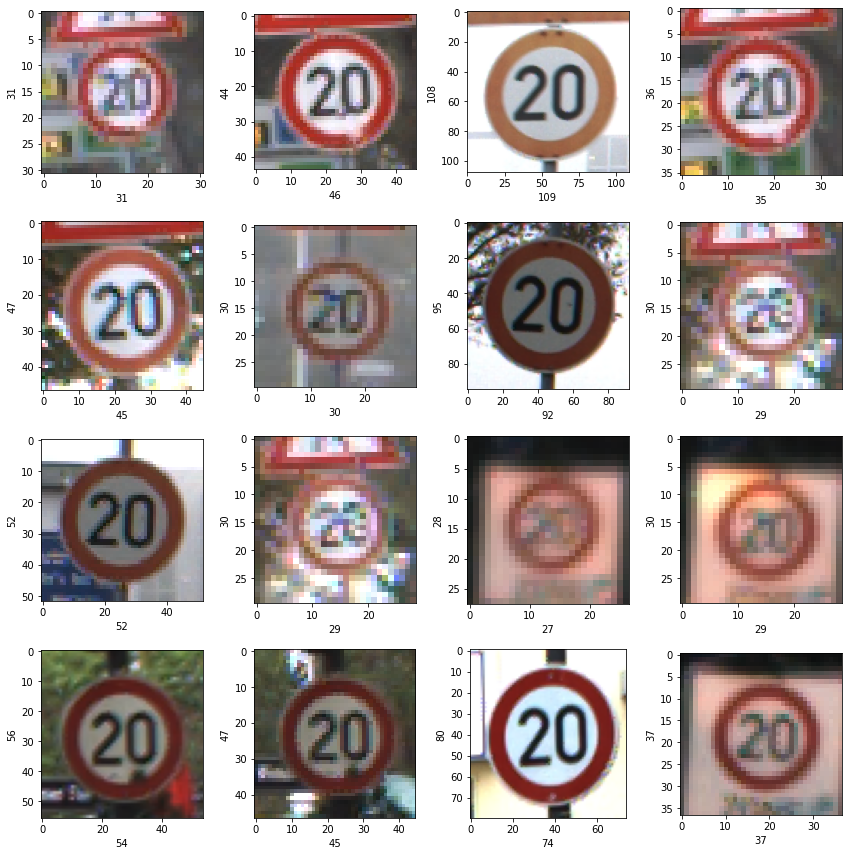

In [12]:
# just a quick explore to see the images
plt.figure(figsize=(12,12))
path = "../data/final_sign_images/Train/0" #Not able to push data to git, give local file path
#path = "./data/German_final_dataset/Train/0"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

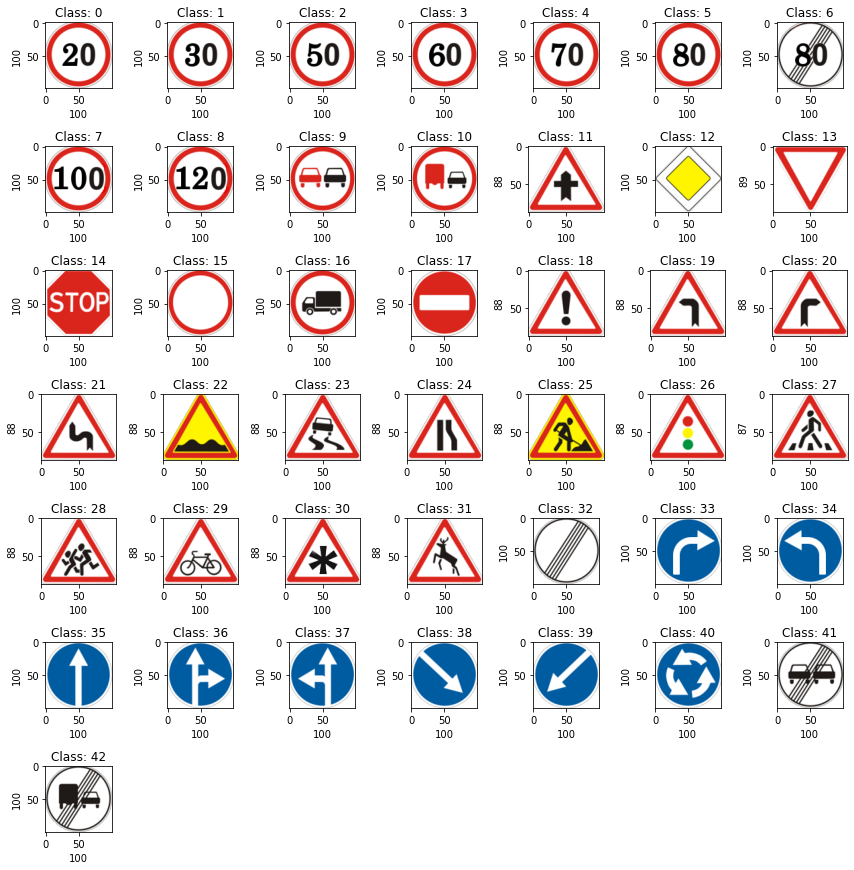

In [13]:
# meta data images for each class
plt.figure(figsize=(12,12))
path = "../data/final_sign_images/Meta/" #Not able to push data to git, give local file path
# no alternate path in git dir just dont run
for i in range(0,43):
    plt.subplot(7,7,i+1)
    plt.tight_layout()
    link_to_image = str(path + str(i) + '.png')
    class_img = imread(link_to_image)
    plt.imshow(class_img)
    plt.xlabel(class_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(class_img.shape[0], fontsize = 10)#height of image
    plt.title("Class: " + str(i))

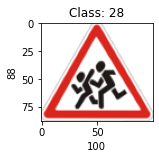

In [14]:
show_class_meta(28)

### Finding mean of dimensions

In [15]:
dim1 = []
dim2 = []
images = []
label_id = []

for i in range(0,43):
    labels = '../data/final_sign_images/Train/'+ str(i)#Not able to push data to git, give local file path
    #labels = './data/German_final_dataset/Train/'+ str(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])
        img = np.array(img)
        images.append(img)
        label_id.append(i)

In [16]:
#Printing mean dimension of images
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.328929582493814  Dimension 2 Mean :  50.83587951745773


### Resize all the images to mean of (50,50)

In [17]:
data = []
images = []
labels = []

for i in range(0,43):
    path = '../data/final_sign_images/Train/'+ str(i)#Not able to push data to git, give local file path
    #path = './data/German_final_dataset/Train/'+ str(i)
    image_path = os.listdir(path)
    for a in image_path:
        link_to_image = str(path + '/'+ a)
        img = Image.open(link_to_image)
        img = img.resize((50,50))
        img = np.array(img)
        data.append(img)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)       

In [18]:
data.shape

(39209, 50, 50, 3)

In [19]:
labels.shape

(39209,)

In [20]:
label_counts = pd.DataFrame(labels).value_counts()
label_counts.head

<bound method NDFrame.head of 2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
35    1200
18    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
34     420
16     420
6      420
22     390
36     390
20     360
40     360
21     330
39     300
29     270
24     270
42     240
41     240
27     240
32     240
19     210
37     210
0      210
dtype: int64>

In [21]:
percent_per_class = label_counts/data.shape[0]*100
percent_per_class.sort_index()

0     0.535591
1     5.661965
2     5.738478
3     3.596113
4     5.049861
5     4.743809
6     1.071183
7     3.672626
8     3.596113
9     3.749139
10    5.126374
11    3.366574
12    5.355913
13    5.508939
14    1.989339
15    1.606774
16    1.071183
17    2.830983
18    3.060522
19    0.535591
20    0.918157
21    0.841644
22    0.994670
23    1.300722
24    0.688617
25    3.825652
26    1.530261
27    0.612104
28    1.377235
29    0.688617
30    1.147696
31    1.989339
32    0.612104
33    1.757250
34    1.071183
35    3.060522
36    0.994670
37    0.535591
38    5.279400
39    0.765130
40    0.918157
41    0.612104
42    0.612104
dtype: float64

Note: The percentage representation of each of the 43 classes is not perfectly balanced it ranges from 0.5% to about 5.7% of the whole dataset.

### Splitting the data

In [22]:
X_train, X_val, y_train, y_val = train_test_split(data, labels , test_size = 0.2, random_state = 42)

In [23]:
print(X_train.shape, X_val.shape, y_train.shape,y_val.shape)

(31367, 50, 50, 3) (7842, 50, 50, 3) (31367,) (7842,)


In [24]:
y_train = to_categorical(y_train,43)
y_val = to_categorical(y_val,43)

In [25]:
X_train.shape[1:]

(50, 50, 3)

In [26]:
# model switches and parameters

# options currently 'A','B', 'VGG16' ?? if i can
model_switch = 'B'

# options to try 10, 15, 20
my_epochs = 10

# options to try  = 'adam','sgd','RMS','ada_delta','ada_max'
my_optimizer = 'adam'

my_metrics = ['accuracy']

# options to try = 32,64,128
my_batch_size = 32

# options = True or False
my_shuffle = True

In [27]:
if (model_switch =='B'):
    print('This model is choosen')
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))

This model is choosen


In [28]:
# model A
if (model_switch =='A'):
    print('This model is choosen')
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = X_train.shape[1:], activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation = 'softmax'))

In [29]:
# model C
if (model_switch =='C'):
    print('This model is choosen')
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = X_train.shape[1:], activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation = 'softmax'))

In [30]:
# Compile model and print its summary
model.compile(loss='categorical_crossentropy', optimizer=my_optimizer, metrics=my_metrics)
#callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [31]:
# Early stoppage is not working ... working on it ...don not delete

#model_file = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
#model_file = "./model_store/temp_model"
#checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
#early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
#tensorboard = TensorBoard(log_dir='../logs', histogram_freq=0,write_graph=True, write_images=False)

In [32]:
#history = model.fit(X_train, y_train, epochs = my_epochs , batch_size = my_batch_size, validation_data = (X_val, y_val), verbose = 2,shuffle = my_shuffle,callbacks = [MetricsCheckpoint('logs'),checkpoint,early])

#print(history)

In [33]:
history = model.fit(X_train, y_train, epochs = my_epochs , batch_size = my_batch_size, validation_data = (X_val, y_val), verbose = 2,shuffle = my_shuffle)
print(history)

Epoch 1/10
981/981 - 89s - loss: 1.3914 - accuracy: 0.6480 - val_loss: 0.2657 - val_accuracy: 0.9338
Epoch 2/10
981/981 - 89s - loss: 0.4375 - accuracy: 0.8727 - val_loss: 0.1312 - val_accuracy: 0.9671
Epoch 3/10
981/981 - 89s - loss: 0.3285 - accuracy: 0.9042 - val_loss: 0.1041 - val_accuracy: 0.9731
Epoch 4/10
981/981 - 90s - loss: 0.2726 - accuracy: 0.9179 - val_loss: 0.0790 - val_accuracy: 0.9804
Epoch 5/10
981/981 - 91s - loss: 0.2338 - accuracy: 0.9305 - val_loss: 0.0810 - val_accuracy: 0.9796
Epoch 6/10
981/981 - 90s - loss: 0.2105 - accuracy: 0.9376 - val_loss: 0.0624 - val_accuracy: 0.9843
Epoch 7/10
981/981 - 90s - loss: 0.2032 - accuracy: 0.9403 - val_loss: 0.0662 - val_accuracy: 0.9816
Epoch 8/10
981/981 - 90s - loss: 0.1841 - accuracy: 0.9444 - val_loss: 0.0506 - val_accuracy: 0.9861
Epoch 9/10
981/981 - 90s - loss: 0.1694 - accuracy: 0.9474 - val_loss: 0.0449 - val_accuracy: 0.9869
Epoch 10/10
981/981 - 90s - loss: 0.1501 - accuracy: 0.9548 - val_loss: 0.0465 - val_accura

## Model Validation

In [34]:
from sklearn.metrics import confusion_matrix
class_label = list(range(0,43))

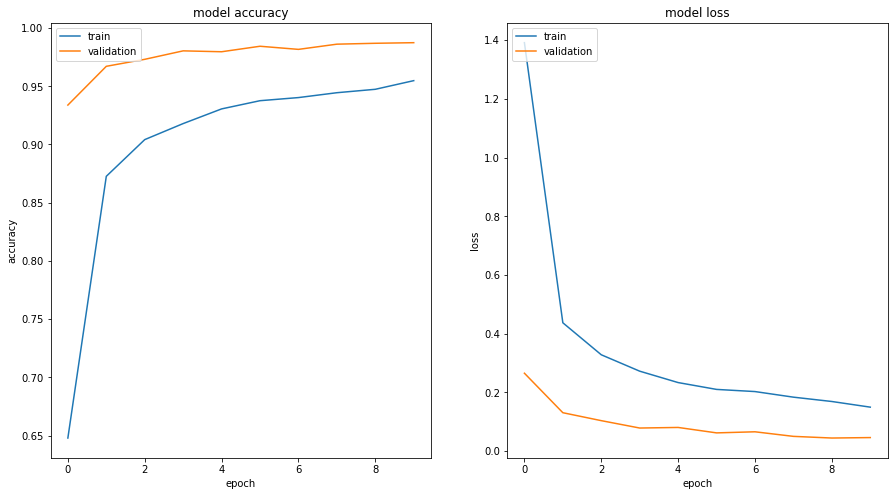

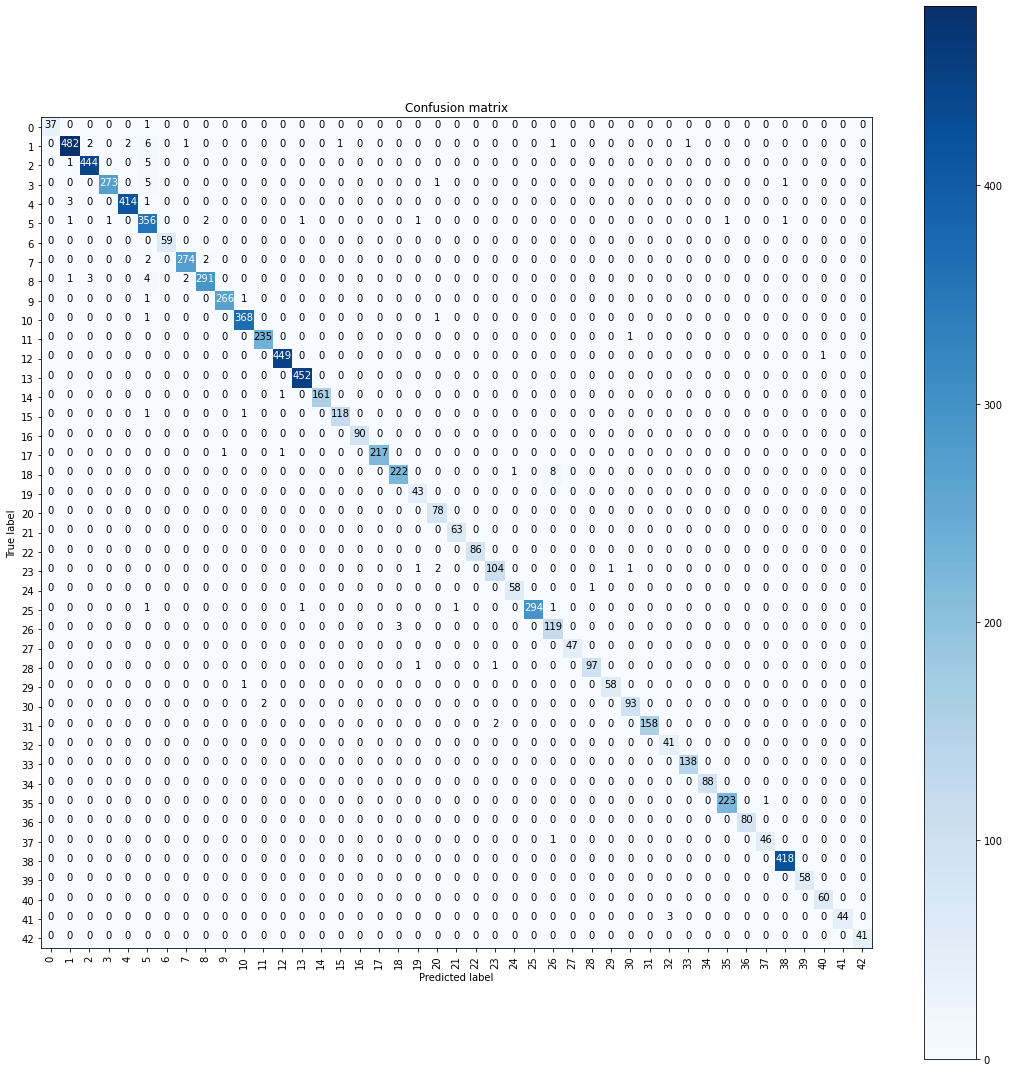

In [49]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred,axis = 1)  # reconverts back from one hot encoded 
y_true = np.argmax(y_val,axis = 1)  # reconverts back from one hot encoded
confusion_mtx = confusion_matrix(y_true,y_pred_classes)
#plotKerasLearningCurve()
plot_learning_curve(history)
plot_confusion_matrix(confusion_mtx, classes = class_label)

In [38]:
#model.save('./model_store/my_model2.h5')

In [44]:
evaluation = pd.DataFrame(history.history)
evaluation

,loss,accuracy,val_loss,val_accuracy
0,1.391413,0.648006,0.265669,0.933818
1,0.437467,0.872669,0.131153,0.967100
2,0.328460,0.904167,0.104107,0.973094
3,0.272621,0.917939,0.078973,0.980362
4,0.233805,0.930532,0.080973,0.979597
5,0.210525,0.937578,0.062441,0.984315
6,0.203178,0.940256,0.066162,0.981637
7,0.184119,0.944432,0.050597,0.986100
8,0.169352,0.947365,0.044913,0.986866
9,0.150101,0.954793,0.046466,0.987376


<AxesSubplot:>

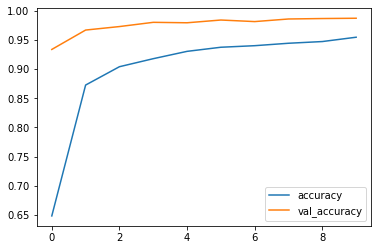

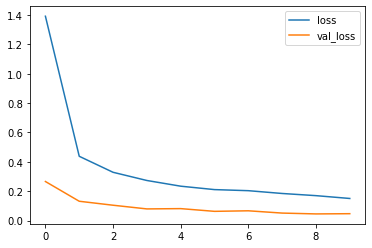

In [45]:
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

In [36]:
error trigger

SyntaxError: invalid syntax (<ipython-input-36-d3cf40fae1a8>, line 1)

In [ ]:
model.save('./models/my_model.h5')

In [ ]:
#this function does not creade ta .h5 file for current model
number_of_epochs = 2
for i in range(1,number_of_epochs):
    model.fit(X_train, y_train, epochs = i , batch_size = 32, validation_data = (X_val, y_val), verbose = 2)
    print(i)
    if(i >= 2 and val_accuracy[i] >= val_accuracy[i-1]):
        model.save('./my_model.h5') 
        


### Visualizations of image data

In [ ]:
# try including
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [ ]:
info_dataset(X_train, X_valid, y_train)

In [ ]:
viz_dataset(X_train, y_train, X_valid, y_valid)

### Data Preprocessing

In [ ]:
n_classes = int(max(y_train)+1)

# Train data set shuffling
X_train, y_train = shuffle(X_train, y_train)

# Data set RGB images to gray scale
nX_train=RGB2GREY(X_train)
nX_valid=RGB2GREY(X_valid)

# Train data set augmentation with image rotation
aug_X, aug_y=expand_dataset(nX_train, y_train)
nX_train=np.concatenate((nX_train,aug_X))
y_train=np.concatenate((y_train,aug_y))

print("Number of training examples with augmented data=", nX_train.shape[0])
print()

# Data set normalization
nX_train=norm_data(nX_train)
nX_valid=norm_data(nX_valid)

# New data set visualization
viz_dataset(nX_train, y_train, nX_valid, y_valid)

### Convolutional Neural Network Architecture

### Evaluation of model

In [ ]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

### Test model on real images

In [ ]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [ ]:
#Test image
print("The Predicted sign: "+ str(model.predict_classes(img)))

### Save model

In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model # deletes the existing model